# Sales forecasting using SARIMA
General Steps:

1) Visualize Time Series Data

2) Make time series data stationary

3) Plot the correlation and autocorrelation charts

4) Construct ARIMA or Seasonal ARIMA model based on the data

5) Use the model to make predictions

In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
# from statsmodels.tsa.arima_model import ARIMA

In [79]:
df=pd.read_csv('perrin-freres-monthly-champagne-.csv')

In [80]:
df.head()

,Month,Perrin Freres monthly champagne sales millions ?64-?72
0,1964-01,2815.0
1,1964-02,2672.0
2,1964-03,2755.0
3,1964-04,2721.0
4,1964-05,2946.0


In [81]:
df.tail()

,Month,Perrin Freres monthly champagne sales millions ?64-?72
102,1972-07,4298.0
103,1972-08,1413.0
104,1972-09,5877.0
105,NaN,NaN
106,Perrin Freres monthly champagne sales millions...,NaN


### Cleaning the data

In [82]:
#Renaming the Sales column
df.columns=['Month','Sales']
df.head()

,Month,Sales
0,1964-01,2815.0
1,1964-02,2672.0
2,1964-03,2755.0
3,1964-04,2721.0
4,1964-05,2946.0


In [83]:
# Removing Nan Values

df.isna().sum()

Month    1
Sales    2
dtype: int64

In [84]:
df.dropna(inplace=True)

In [85]:
# convert month to datetime

df['Month']=pd.to_datetime(df['Month'])
df.head()

,Month,Sales
0,1964-01-01,2815.0
1,1964-02-01,2672.0
2,1964-03-01,2755.0
3,1964-04-01,2721.0
4,1964-05-01,2946.0


In [86]:
# making date the index 

df.set_index('Month',inplace=True)
df.head()

,Sales
Month,
1964-01-01,2815.0
1964-02-01,2672.0
1964-03-01,2755.0
1964-04-01,2721.0
1964-05-01,2946.0


### Visualizing the Data

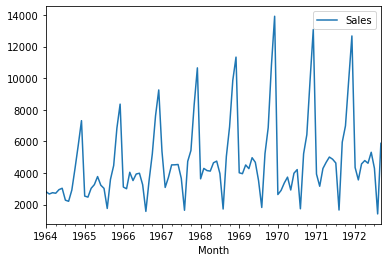

In [87]:
df.plot()

#data looks seasonal(multiplicative) on visualizing however there is not much trend here

### Testing if Data is stationary
Using Dickey-Fuller test

In [88]:
# Testing if data is stationary or not
# we'll use dickey-fuller test for this
#Dickey- Fuller is a hypothesis testing method with return 4 values
# (ADF test stats, p-value, #Lags used,num of observations used)

from statsmodels.tsa.stattools import adfuller


In [89]:
#H0: it is not stationary
#H1L it is stationary

def adfuller_test(sales):
    result=adfuller(sales)
    labels=['ADF Test Statistic','p_value','#Lags Used','Number of Observations Used' ]
    for value, label in zip(result,labels):
        print(label+' : '+str(value))
    if result[1] < 0.05:
        print("Strong Eveidence against the null hypothesis(Ho),Reject the null hypothesis. Data is stationary")
    else:
        print("Weak evidence against the null hypothesis(Ho), Failed to reject Ho. Data is not stationary")

In [90]:
adfuller_test(df['Sales'])

ADF Test Statistic : -1.8335930563276297
p_value : 0.3639157716602417
#Lags Used : 11
Number of Observations Used : 93
Weak evidence against the null hypothesis(Ho), Failed to reject Ho. Data is not stationary


### Differencing
To make the data stationary

In differecing We will subtract previous/next lag by current value and then we will be able to remove trend/seasonality.

In [91]:
#Since the data is seasonal as seen in the graph, we'll shift by 12 as monthtly data is there
# shifting by 1 won't make sense as it's a monthly seasonal data

df['Seasonal First Difference']=df['Sales']-df['Sales'].shift(12)

In [92]:
df

,Sales,Seasonal First Difference
Month,,
1964-01-01,2815.0,NaN
1964-02-01,2672.0,NaN
1964-03-01,2755.0,NaN
1964-04-01,2721.0,NaN
1964-05-01,2946.0,NaN
...,...,...
1972-05-01,4618.0,-392.0
1972-06-01,5312.0,438.0
1972-07-01,4298.0,-335.0


In [93]:
# now we'll use dickey-fuller method to test if seasonal shift has made the  data stationary or not

adfuller_test(df['Seasonal First Difference'].dropna())  # by dropping NA to avoid errors

ADF Test Statistic : -7.626619157213163
p_value : 2.060579696813685e-11
#Lags Used : 0
Number of Observations Used : 92
Strong Eveidence against the null hypothesis(Ho),Reject the null hypothesis. Data is stationary


In [94]:
# hence from the above results we can confirm that data is now stationary after using differencing

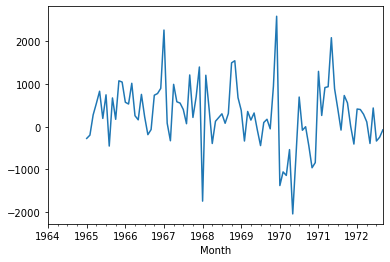

In [95]:
df['Seasonal First Difference'].plot()

# we can see the seaonality is removed and only irreularities remain

### Auto Regressive Model


* Identification of an MA model is often best done with the ACF rather than the PACF.

* Identification of an AR model is often best done with the PACF.

* p,d,q

    * p specifies AR model lags
    * d specifies differencing (I)
    * q specifies MA lags

* Identification of an AR model is often best done with the PACF.
    * For an AR model, the theoretical PACF “shuts off” past the order of the model.  The phrase “shuts off” means that in theory the partial autocorrelations are equal to 0 beyond that point.  Put another way, the number of non-zero partial autocorrelations gives the order of the AR model.  By the “order of the model” we mean the most extreme lag of x that is used as a predictor.
    
    
* Identification of an MA model is often best done with the ACF rather than the PACF.
    * For an MA model, the theoretical PACF does not shut off, but instead tapers toward 0 in some manner.  A clearer pattern for an MA model is in the ACF.  The ACF will have non-zero autocorrelations only at lags involved in the model.

In [96]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf


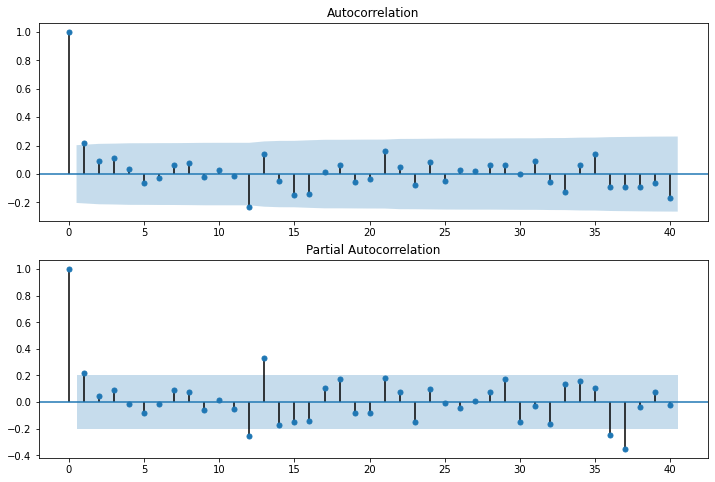

In [97]:
fig = plt.figure(figsize=(12,8))
ax1=fig.add_subplot(211)  
fig=plot_acf(df['Seasonal First Difference'].dropna(), lags=40,ax=ax1)
ax2= fig.add_subplot(212)
fig=plot_pacf(df['Seasonal First Difference'].dropna(), lags=40,ax=ax2)

In [ ]:
# from the above graph we can find the p(AR-PACF) and q(MA-ACF) values
# we kow for AR models, PACF shuts off past the order of model, in the PACF graph we can see that PACF shuts off after point 1,
# hence p=1
# we know for MA models, ACF, tapers towrads 0 rather than shutting off, but in ACF we do not see it tapering off past point 1,
# hence we could take q= 0 or q= 1

# for difference, we had earlier shifted the data only once, hence only one order was needed to make data stationary
# hence we take d=1 

### Modelling

In [98]:
# since data is seasonal, we will be using Seasonal ARIMA, i.e. SARIMA 
# SARIMA
# p=1, d=1, q =1 or 0

import statsmodels.api as sm


In [99]:
model= sm.tsa.statespace.SARIMAX(df['Sales'],order=(1,1,1),seasonal_order=(1,1,1,12))  #p,d,q
results=model.fit()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


### Testing Forecast

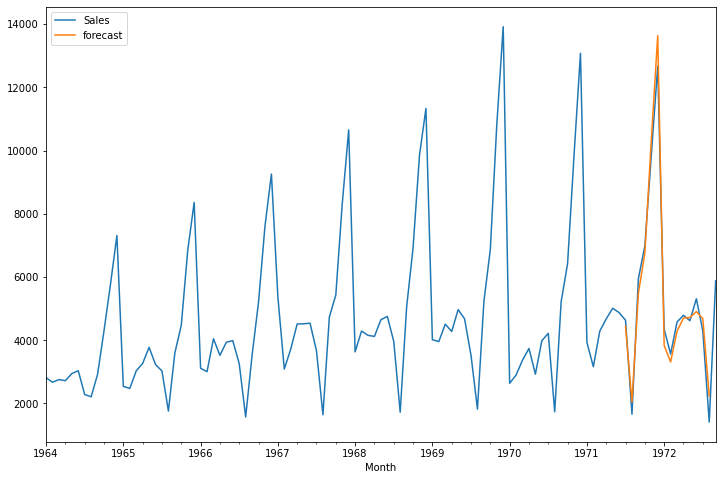

In [100]:
#Testing forecast on the existing dataset to check the model

#creating a forecast column on the existing df
df['forecast']=results.predict(start=90,end=103,dynamic=True)
df[['Sales','forecast']].plot(figsize=(12,8))

### Actual Forecasting

In [101]:
# creating additional dates for 24 months (for future forecasting)

from pandas.tseries.offsets import DateOffset
future_dates=[df.index[-1]+DateOffset(months=x) for x in range(0,24)]

In [102]:
# creating data frame with all the columns from original df
future_dates_df=pd.DataFrame(index=future_dates[1:],columns=df.columns)

In [103]:
future_dates_df.head()

,Sales,Seasonal First Difference,forecast
1972-10-01,NaN,NaN,NaN
1972-11-01,NaN,NaN,NaN
1972-12-01,NaN,NaN,NaN
1973-01-01,NaN,NaN,NaN
1973-02-01,NaN,NaN,NaN


In [104]:
# concatenating the original df with the new forecasting df,

future_df=pd.concat([df,future_dates_df])

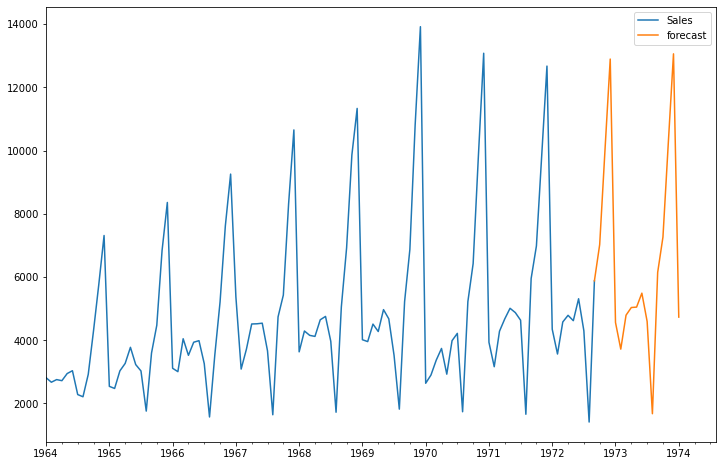

In [105]:
future_df['forecast']=results.predict(start=104,end=120,dynamic=True)
future_df[['Sales','forecast']].plot(figsize=(12,8))